In [1]:
include("/Users/meesvandartel/Desktop/Coursework/CGT/DeepEWA/FastEWA.jl")
using Flux, .fEWA, Random, IterTools, ProgressMeter, DataFrames, CSV, Statistics

In [2]:
# this data will be for this specific coordination game with 2 NE and 1 mixed NE.
coord = [[[5 1; 1 4], [5 1; 1 4]], fEWA.find_NE_mixed([[5 1; 1 4], [5 1; 1 4]])]
dom = [[[5 0; 20 1], [5 0; 20 1]], fEWA.find_NE_mixed([[5 0; 20 1], [5 0; 20 1]])]
cyclic = [[[5 1;1 4],[-5 1; 1 -4]], fEWA.find_NE_mixed([[5 1;1 4],[-5 1; 1 -4]])]

game = cyclic
points = 5000 

α_grid = rand(0.0:0.0001:1.0, points) 
κ_grid = rand(0.0:0.0001:1.0, points)
δ_grid = rand(0.0:0.0001:1.0, points)
β_grid = exp.(rand(0.0:0.001:6.0, points)) # take exp to get the lim to infty effect since β is unbounded above
combs = [[α_grid[i], κ_grid[i], δ_grid[i], β_grid[i]] for i in 1:points]
subset=Int64(floor(0.6*length(combs))) #60/40 train test split, since we have many obs

x_train, x_test = combs[1:subset], combs[(subset+1):end]
y_train, y_test = Vector{Bool}(undef, length(x_train)),Vector{Bool}(undef, length(x_test))
println("Finished")

Finished


In [3]:
# should take about 6min for 1mil obs
@showprogress for i in 1:length(x_train)
    comb=x_train[i]
    α, κ, δ, β = comb
    params = fEWA.init_EWA(;α=α, κ=κ, δ=δ, β=β,game=game)
    sₜ, σ, Qₜ, NE_found  = fEWA.Run_FastEWA(params)
    y_train[i] = NE_found
end

@showprogress for i in 1:length(x_test)
    comb = x_test[i]
    α, κ, δ, β = comb
    params = fEWA.init_EWA(;α=α, κ=κ, δ=δ, β=β,game=game)
    _, _, _, NE_found  = fEWA.Run_FastEWA(params)
    y_test[i] = NE_found
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


In [4]:
x_train = hcat([Float32.(x[1:4]) for x in x_train]...)

DeepEWA= Chain(
    Dense(4 => 4, relu),
    Dense(4 => 4, relu),
    Dense(4 => 2))

out1 = DeepEWA(x_train)
probs1 = softmax(out1)


target = Flux.onehotbatch(y_train, [true, false])
loader = Flux.DataLoader((x_train, target), batchsize=64, shuffle=true);

opt_state = Flux.setup(Flux.Adam(0.01), DeepEWA)

losses=[]
@showprogress for epoch in 1:1000
    for xy in loader
        x,y = xy
        loss, grads = Flux.withgradient(DeepEWA) do m
            y_hat = m(x)
            Flux.logitcrossentropy(y_hat, y)
        end
        Flux.update!(opt_state, DeepEWA, grads[1])
        push!(losses, loss)
    end
end

opt_state

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


(layers = ((weight = Leaf(Adam(eta=0.01, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[6.0f-45 6.0f-45 6.0f-45 6.0f-45; -0.00101227 -0.00106073 -0.000849103 -0.00146811; -0.00417111 -0.000207829 -0.00087507 -0.0399891; -0.0042088 -0.00469015 -0.00190919 -0.0224538], Float32[1.01554f-29 3.02898f-33 2.38415f-32 1.50222f-29; 0.000147786 0.000113443 0.000140308 0.000359871; 0.000179605 0.0001509 4.15699f-5 0.276464; 0.000159183 0.000129823 0.000106347 0.00495661], (6.0f-45, 3.78249f-21))), bias = Leaf(Adam(eta=0.01, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[6.0f-45, -0.00131977, -0.00619658, -0.0100403], Float32[1.46072f-29, 0.000262729, 0.000586099, 0.000510051], (6.0f-45, 3.78249f-21))), σ = ()), (weight = Leaf(Adam(eta=0.01, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[6.0f-45 -3.26317f-9 0.0189338 8.51738f-6; 0.0 0.0 0.0 0.0; -6.0f-45 -6.0f-45 0.00288762 0.0208498; -6.0f-45 -1.38664f-5 -0.00259732 0.00155921], Float32[2.14645f-34 5.07188f-11 0.0129612 4.22435f-8; 0.0 0.0 0.0 0.0; 3.4

In [5]:
out2 = DeepEWA(x_train)
probs2 = softmax(out2)
mean((probs2[1,:].>0.5).==y_train)

0.8233333333333334

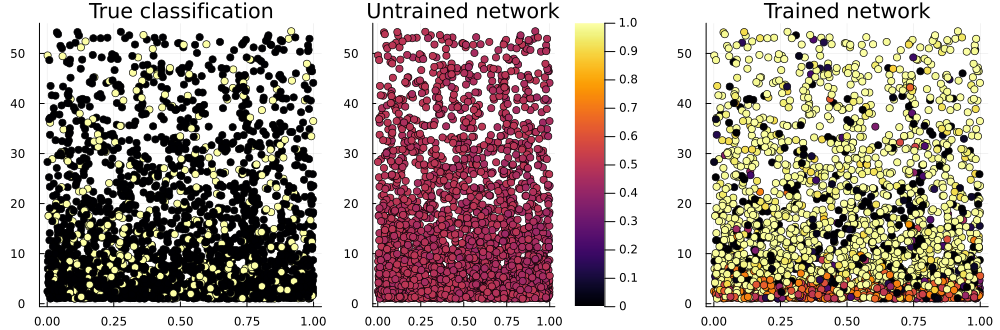

In [8]:
using Plots  # to draw the above figure

p_true = scatter(x_train[1,:], x_train[4,:], zcolor=y_train, title="True classification", legend=false)
p_raw =  scatter(x_train[1,:], x_train[4,:], zcolor=probs1[1,:], title="Untrained network", label="", clims=(0,1))
p_done = scatter(x_train[1,:], x_train[4,:], zcolor=probs2[1,:], title="Trained network", legend=false)

plot(p_true, p_raw, p_done, layout=(1,3), size=(1000,330))


In [7]:

#=
plot(losses; xaxis=(:log10, "iteration"),
    yaxis="loss", label="per batch")
n = length(loader)
plot!(n:n:length(losses), mean.(Iterators.partition(losses, n)),
    label="epoch mean", dpi=200)
    =#
